# Malware Credential Leaks – Tor Market Data (2019–2022)

This notebook analyzes leaked credentials collected from malware-infected systems,
using data scraped from Tor markets between 2019–2022.

**Main questions:**
1. Which countries are most affected (excluding UNKNOWN)?
2. Which services / domains show up most frequently?
3. How bad is password hygiene (weak passwords, reuse)?
4. Case studies:
   - Compare Google vs Facebook vs Microsoft services
   - Compare a high-volume country vs another

Data source:
"Malware Finances and Operations: a Data-Driven Study of the Value Chain for Infections and Compromised Access"
Nurmi, Niemelä, Brumley – Zenodo dataset (2019–2022).


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
import pycountry
import seaborn as sns


# === DB CONFIG ===
DB_NAME = "leakatlas"
DB_USER = "postgres"
DB_PASS = "123456"
DB_HOST = "localhost"
DB_PORT = 5433

conn_str = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(conn_str)


In [49]:
# ===== GLOBAL SEABORN STYLE =====
sns.set_theme(style="darkgrid", context="talk", palette="flare")


# Default figure size for all plots
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 120

In [30]:
def code_to_country(alpha2):
    if not isinstance(alpha2, str):
        return None
    try:
        return pycountry.countries.get(alpha_2=alpha2.upper()).name
    except:
        return None

In [31]:
# core aggregates
query_records = """
SELECT
    record_id,
    country,
    timestamp,
    device_ip_addr,
    password_count,
    domain_count,
    service_count,
    username_count,
    email_count
FROM record_aggregates
WHERE timestamp BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
  AND country IS NOT NULL
  AND country <> ''
  AND country <> 'UNKNOWN';
"""

records_df = pd.read_sql(query_records, engine)
records_df = records_df.dropna(subset=['timestamp'])
records_df['timestamp'] = pd.to_datetime(records_df['timestamp'], errors='coerce')
records_df['country_name'] = records_df['country'].apply(code_to_country)

records_df.head()


,record_id,country,timestamp,device_ip_addr,password_count,domain_count,service_count,username_count,email_count,country_name
0,695769,TR,2019-09-07,067585f445,3,5,2,3,2,Türkiye
1,452377,MA,2020-12-01,ec59be82e0,68,72,59,68,21,Morocco
2,544632,KE,2020-07-01,92b7a0bb10,1,2,1,1,0,Kenya
3,630986,BR,2019-08-06,4b43db181a,3,7,3,4,2,Brazil
4,647176,TR,2019-08-04,8bc13ec788,1,4,1,1,1,Türkiye


In [3]:
# records per year
records_df['year'] = records_df['timestamp'].dt.year


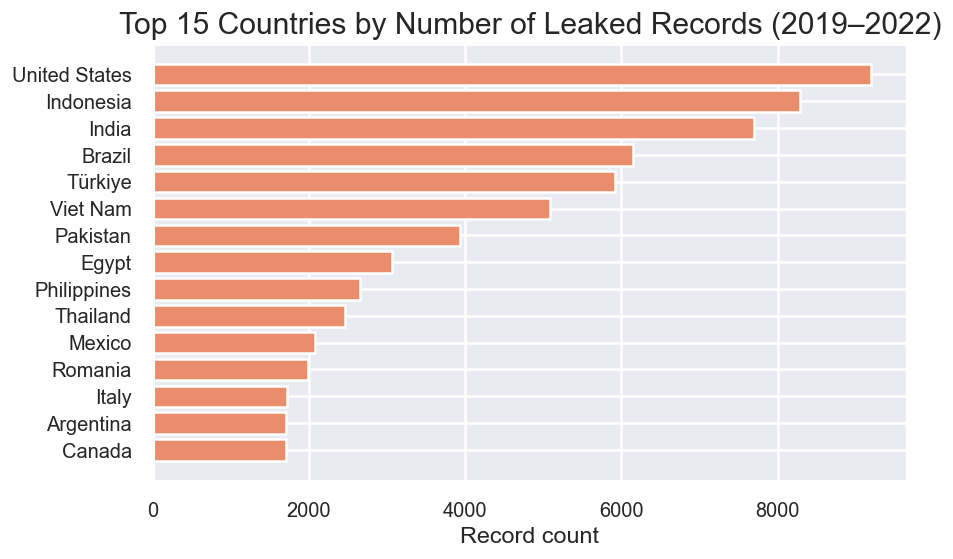

In [50]:
country_counts = (
    records_df
    .groupby('country_name')
    .size()
    .rename('record_count')
    .reset_index()
    .sort_values('record_count', ascending=False)
    .head(15)
)

plt.figure(figsize=(8,5))
plt.barh(country_counts['country_name'], country_counts['record_count'])
plt.gca().invert_yaxis()
plt.title("Top 15 Countries by Number of Leaked Records (2019–2022)")
plt.xlabel("Record count")
plt.tight_layout()
plt.show()



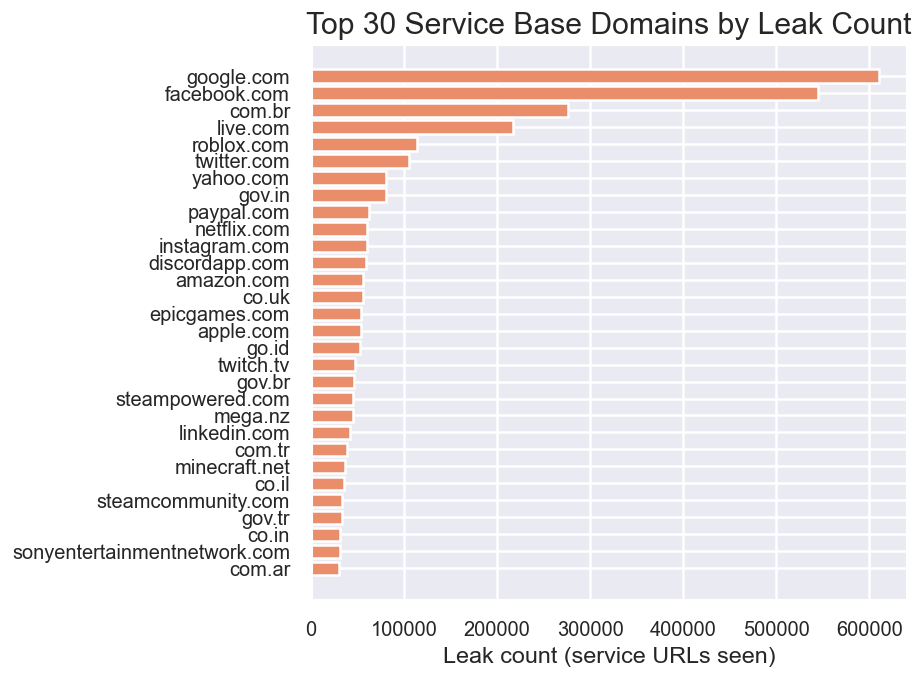

In [51]:
# Top service base domains (top 30)

query_services = """
SELECT base_domain, leak_count, distinct_records
FROM vw_service_domain_usage
ORDER BY leak_count DESC
LIMIT 30;
"""

services_df = pd.read_sql(query_services, engine)

plt.figure(figsize=(8,6))
plt.barh(services_df['base_domain'], services_df['leak_count'])
plt.gca().invert_yaxis()
plt.title("Top 30 Service Base Domains by Leak Count")
plt.xlabel("Leak count (service URLs seen)")
plt.tight_layout()
plt.show()



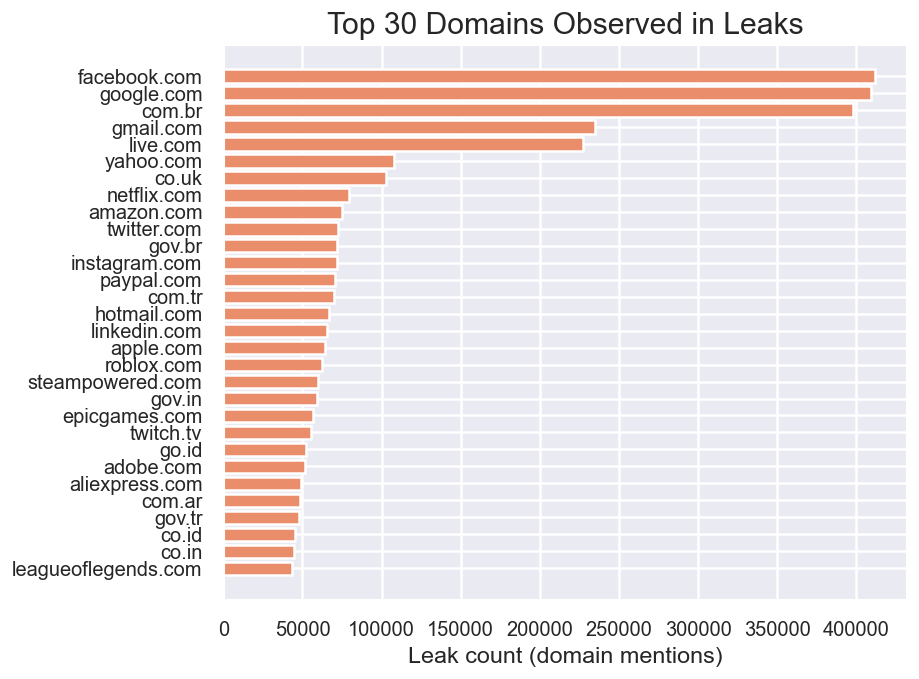

In [52]:
# top raw domains

query_domains = """
SELECT base_domain, leak_count, distinct_records
FROM vw_domain_base_usage
ORDER BY leak_count DESC
LIMIT 30;
"""

domains_df = pd.read_sql(query_domains, engine)

plt.figure(figsize=(8,6))
plt.barh(domains_df['base_domain'], domains_df['leak_count'])
plt.gca().invert_yaxis()
plt.title("Top 30 Domains Observed in Leaks")
plt.xlabel("Leak count (domain mentions)")
plt.tight_layout()
plt.show()


In [53]:
# global password hygene

query_weak = """
SELECT password, occurrences, distinct_records
FROM weak_passwords
ORDER BY occurrences DESC
LIMIT 50;
"""

weak_df = pd.read_sql(query_weak, engine)
weak_df.head()


,password,occurrences,distinct_records
0,a472e13779,116320,34174
1,e9c49f0dd4,84007,31808
2,f60cf66187,78931,19763
3,af8d63ddb1,59209,18197
4,0abd53be14,19033,7418


In [54]:
query_weak_flag = """
SELECT
    has_weak_password,
    COUNT(*) AS record_count
FROM record_aggregates
WHERE timestamp BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
  AND country IS NOT NULL
  AND country <> ''
  AND country <> 'UNKNOWN'
GROUP BY has_weak_password;
"""

weak_flag_df = pd.read_sql(query_weak_flag, engine)
weak_flag_df


,has_weak_password,record_count
0,False,58882
1,True,48041


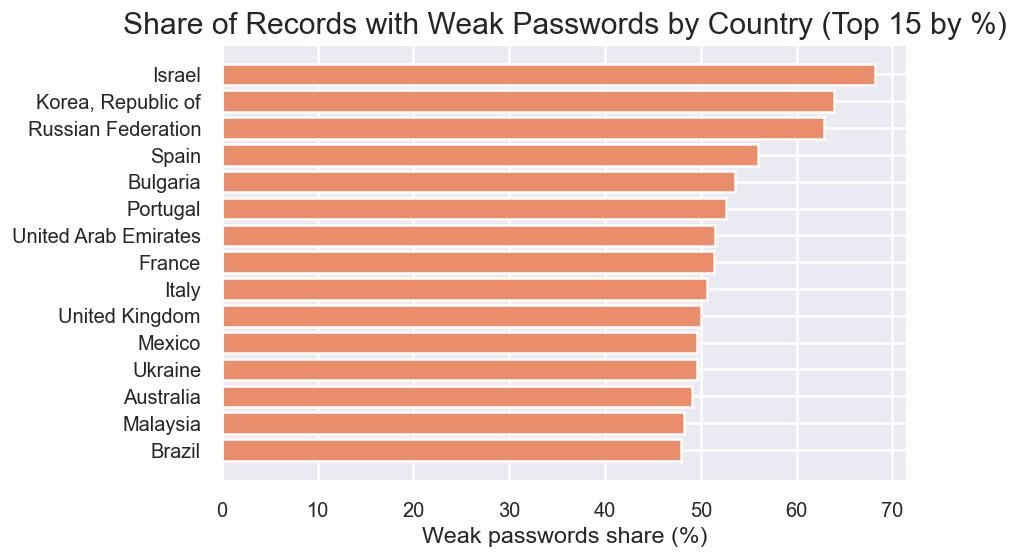

In [55]:
# weak password share by country (top 10)

query_weak_by_country = """
WITH filtered AS (
    SELECT
        ra.record_id,
        ra.country,
        ra.has_weak_password
    FROM record_aggregates ra
    WHERE ra.timestamp BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
      AND ra.country IS NOT NULL
      AND ra.country <> ''
      AND ra.country <> 'UNKNOWN'
)
SELECT
    country,
    COUNT(*) AS total_records,
    SUM(CASE WHEN has_weak_password THEN 1 ELSE 0 END) AS weak_records,
    ROUND(
        100.0 * SUM(CASE WHEN has_weak_password THEN 1 ELSE 0 END) / COUNT(*),
        2
    ) AS weak_share_pct
FROM filtered
GROUP BY country
HAVING COUNT(*) > 500
ORDER BY weak_share_pct DESC
LIMIT 15;
"""

weak_country_df = pd.read_sql(query_weak_by_country, engine)
weak_country_df['country_name'] = weak_country_df['country'].apply(code_to_country)

plt.figure(figsize=(8,5))
plt.barh(weak_country_df['country_name'], weak_country_df['weak_share_pct'])
plt.gca().invert_yaxis()
plt.title("Share of Records with Weak Passwords by Country (Top 15 by %)")
plt.xlabel("Weak passwords share (%)")
plt.tight_layout()
plt.show()



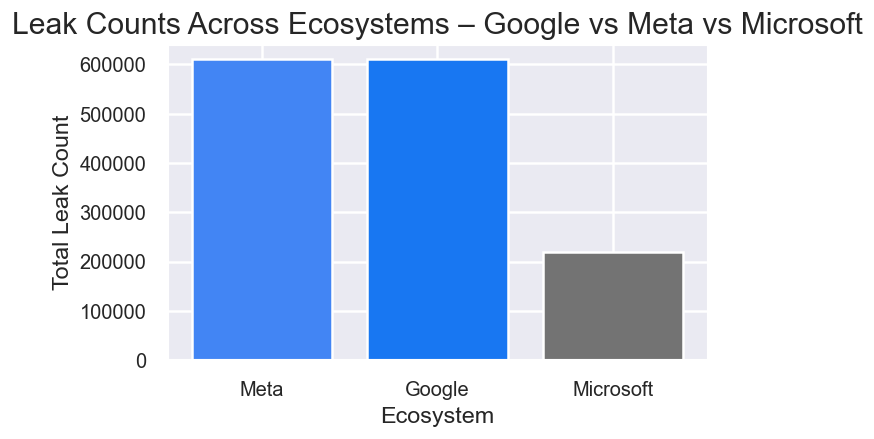

In [56]:
# Case Study 1 [Google v Facebook v MS Services]
"""
Which ecosystem (Google / Meta / Microsoft) shows up more in leaked credentials?
How might that relate to how deeply they’re woven into daily life?
# combine 3 of ms into one.
"""

query_ecosystems = """
WITH mapped AS (
    SELECT
        base_domain,
        leak_count,
        distinct_records,
        CASE
            WHEN base_domain IN ('google.com', 'gmail.com') THEN 'Google'
            WHEN base_domain IN ('facebook.com', 'fb.com', 'messenger.com', 'instagram.com') THEN 'Meta'
            WHEN base_domain IN ('live.com', 'outlook.com', 'hotmail.com', 'microsoft.com') THEN 'Microsoft'
            ELSE 'Other'
        END AS ecosystem
    FROM vw_service_domain_usage
)
SELECT
    ecosystem,
    SUM(leak_count) AS total_leaks,
    SUM(distinct_records) AS total_records
FROM mapped
WHERE ecosystem IN ('Google', 'Meta', 'Microsoft')
GROUP BY ecosystem
ORDER BY total_leaks DESC;
"""


eco_df = pd.read_sql(query_ecosystems, engine)


plt.figure(figsize=(6, 4))
plt.bar(eco_df['ecosystem'], eco_df['total_leaks'], color=['#4285F4','#1877F2','#737373'])
plt.title("Leak Counts Across Ecosystems – Google vs Meta vs Microsoft")
plt.xlabel("Ecosystem")
plt.ylabel("Total Leak Count")
plt.tight_layout()
plt.show()


In [57]:
# Case Study 2: Country Specific

FOCUS_COUNTRY = "US"  # change as needed

country_name = code_to_country(FOCUS_COUNTRY)

query_focus = f"""
SELECT
    ra.record_id,
    ra.country,
    ra.timestamp,
    ra.password_count,
    ra.domain_count,
    ra.service_count,
    ra.username_count,
    ra.email_count,
    ra.has_weak_password
FROM record_aggregates ra
WHERE ra.timestamp BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
  AND ra.country = '{FOCUS_COUNTRY}';
"""

focus_df = pd.read_sql(query_focus, engine)


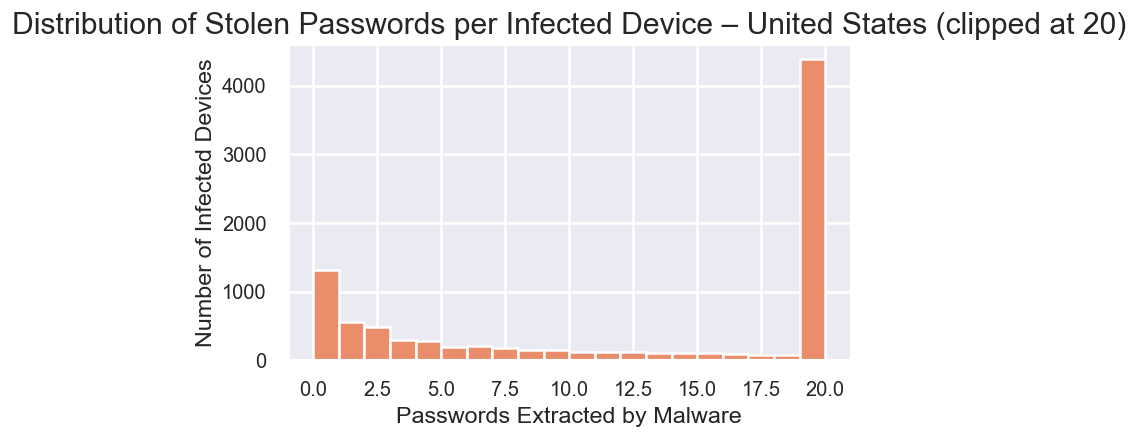

In [58]:
# Case Study 2.1: Distribution of password counts per record
focus_df['password_count'].describe()

plt.figure(figsize=(6,4))
focus_df['password_count'].clip(upper=20).hist(bins=20)
plt.title(f"Distribution of Stolen Passwords per Infected Device – {country_name} (clipped at 20)")
plt.xlabel("Passwords Extracted by Malware")
plt.ylabel("Number of Infected Devices")
plt.tight_layout()
plt.show()


In [61]:
# case study 2.1: Weak password share

weak_share_focus = (
    focus_df['has_weak_password']
    .value_counts(normalize=True)
    .rename(index={True: 'weak', False: 'non_weak'})
    * 100
)
weak_share_focus


has_weak_password
non_weak    54.800478
weak        45.199522
Name: proportion, dtype: float64

<>:52: SyntaxWarning: invalid escape sequence '\.'
<>:52: SyntaxWarning: invalid escape sequence '\.'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_39968\195172300.py:52: SyntaxWarning: invalid escape sequence '\.'
  """


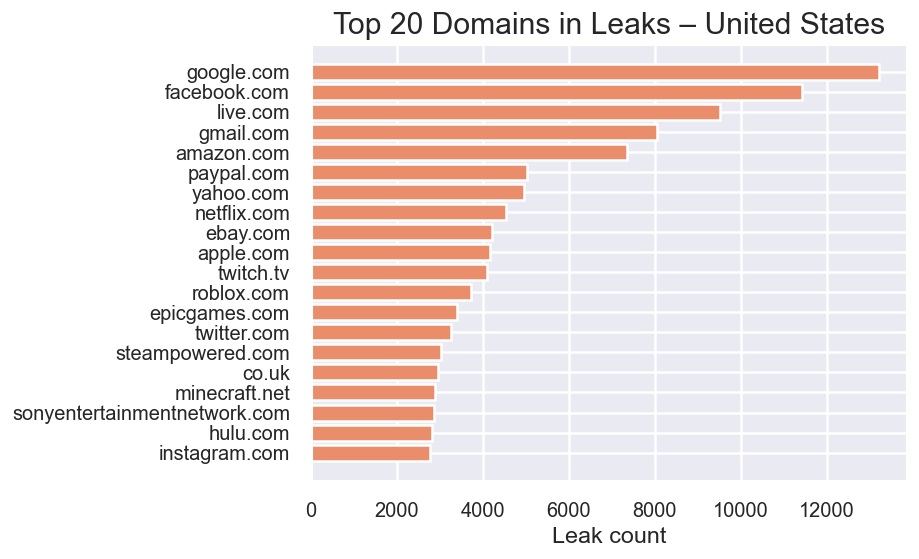

In [60]:
# case study 2.1: Top domains in that country

query_country_domains = f"""
WITH filtered AS (
    SELECT r.id AS record_id
    FROM records r
    WHERE r.country = '{FOCUS_COUNTRY}'
      AND r.timestamp BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
),

normalized AS (
    SELECT
        dn.record_id,
        LOWER(TRIM(dn.domain)) AS domain_clean
    FROM domain_names dn
    JOIN filtered f ON dn.record_id = f.record_id
    WHERE dn.domain IS NOT NULL
      AND dn.domain <> ''
      -- keep only "normal" domains: letters / digits / dot / hyphen
      AND LOWER(TRIM(dn.domain)) ~ '^[a-z0-9.-]+$'
      -- must contain at least one dot
      AND POSITION('.' IN LOWER(TRIM(dn.domain))) > 0
),

parts AS (
    SELECT
        record_id,
        domain_clean,
        regexp_split_to_array(domain_clean, '\.') AS labels
    FROM normalized
),

final AS (
    SELECT
        record_id,
        CASE
            WHEN array_length(labels, 1) >= 2
            THEN labels[array_length(labels, 1) - 1] || '.' || labels[array_length(labels, 1)]
            ELSE domain_clean
        END AS base_domain
    FROM parts
)

SELECT
    base_domain,
    COUNT(*) AS leak_count
FROM final
WHERE base_domain IS NOT NULL
GROUP BY base_domain
ORDER BY leak_count DESC
LIMIT 20;
"""

country_domains_df = pd.read_sql(query_country_domains, engine)

country_domains_df.head(20)


plt.figure(figsize=(8,5))
plt.barh(country_domains_df['base_domain'], country_domains_df['leak_count'])
plt.gca().invert_yaxis()
plt.title(f"Top 20 Domains in Leaks – {country_name}")
plt.xlabel("Leak count")
plt.tight_layout()
plt.show()



# Summary – Story from the Data

1. **Timeframe (2019–2022)**  
   - Showed X → Y growth/decline in number of infected records.

2. **Geography (excluding UNKNOWN)**  
   - Top affected countries: A, B, C.  
   - These countries represent N% of all records in the dataset.

3. **Services / Domains**  
   - Most frequently appearing base domains: google.com, facebook.com, etc.  
   - These reflect everyday services where stored credentials are being stolen.

4. **Password hygiene**  
   - High-frequency weak passwords ("123456", "password", etc.) appear in Z% of records.  
   - Some countries show >N% weak password usage among infected devices.

5. **Case study country (e.g. IN)**  
   - Average passwords per record: X  
   - Weak password share: Y%  
   - Dominant leaked domains: list them.

6. **Case study services (Google vs Meta vs Microsoft)**  
   - Which ecosystem appears more in stolen credentials.  
   - Interpreted as: how closely those services are tied to people’s digital lives.

This turns the raw Tor-scraped credential data into a coherent story about:
**who is getting hit, where, through what services, and how user behavior (weak passwords) contributes to the problem.**
